# MobileNet - Rabin Augmented Data v2
# Conclusion: 99.35% but some instabiliy

In [1]:
import os

test_dir ="Rabin Data/Test - Augmented/"
train_dir = "Rabin Data/Train - Augmented/"

# Count total images in training set
count_train = sum([len(files) for r, d, files in os.walk(train_dir)])
count_test = sum([len(files) for r, d, files in os.walk(test_dir)])


In [2]:
from keras.preprocessing.image import ImageDataGenerator

train = ImageDataGenerator()
traindata = train.flow_from_directory(directory=train_dir,target_size=(224,224))
test = ImageDataGenerator()
testdata = test.flow_from_directory(directory=test_dir, target_size=(224,224), shuffle = False)

Found 31155 images belonging to 5 classes.
Found 13300 images belonging to 5 classes.


In [3]:
from tensorflow import keras
img_shape = (224, 224, 3)

model = keras.applications.MobileNet(include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=img_shape,
    pooling='max',
    classes=5, alpha=1, depth_multiplier=2,dropout=.5)

print(model.summary())

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 64)      576       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 64

In [17]:
lr, epochs =  0.0001, 20
loss = keras.losses.CategoricalCrossentropy()
trainer = keras.optimizers.RMSprop(learning_rate=lr)
steps_per_epoch = count_train//64
validation_steps = count_test//64

save_it= keras.callbacks.ModelCheckpoint(filepath='rabin_a_mobile_v2.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', options=None)

model.compile(loss=loss,optimizer=trainer,metrics=['accuracy'])
my_model = model.fit(traindata, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data = testdata, validation_steps = validation_steps, verbose=1, callbacks=save_it)

print(my_model)

Epoch 1/20
486/486 [==============================] - 3157s 6s/step - loss: 0.0707 - accuracy: 0.9747 - val_loss: 0.0459 - val_accuracy: 0.9838
Epoch 2/20
486/486 [==============================] - 2897s 6s/step - loss: 0.0598 - accuracy: 0.9799 - val_loss: 0.0320 - val_accuracy: 0.9914
Epoch 3/20
486/486 [==============================] - 2770s 6s/step - loss: 0.0569 - accuracy: 0.9821 - val_loss: 0.1606 - val_accuracy: 0.9603
Epoch 4/20
486/486 [==============================] - 2797s 6s/step - loss: 0.0454 - accuracy: 0.9839 - val_loss: 0.1112 - val_accuracy: 0.9630
Epoch 5/20
486/486 [==============================] - 2798s 6s/step - loss: 0.0425 - accuracy: 0.9857 - val_loss: 0.3105 - val_accuracy: 0.9286
Epoch 6/20
486/486 [==============================] - 3155s 6s/step - loss: 0.0380 - accuracy: 0.9866 - val_loss: 0.6188 - val_accuracy: 0.8709
Epoch 7/20
486/486 [==============================] - 3427s 7s/step - loss: 0.0333 - accuracy: 0.9887 - val_loss: 0.1102 - val_accuracy:

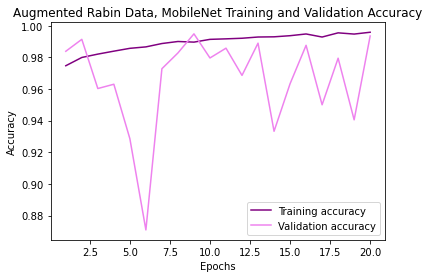

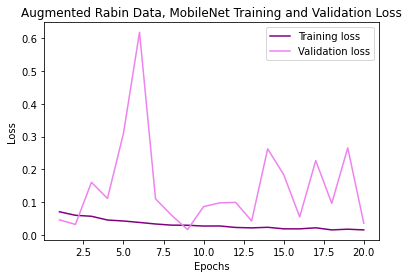

In [18]:
import utilities as u
import numpy as np

# Plot results
u.plot_results(my_model, epochs, "Augmented Rabin Data, MobileNet")


In [19]:
# Save weights
model.save_weights('Rabin Mobilenetv2.params')


In [20]:
# Evaluate the model on the test set
y_pred=np.argmax(model.predict(testdata), axis=-1)
classes = list(testdata.class_indices.keys())


[0 0 0 ... 4 4 4]
['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
[0 0 0 ... 4 4 4]


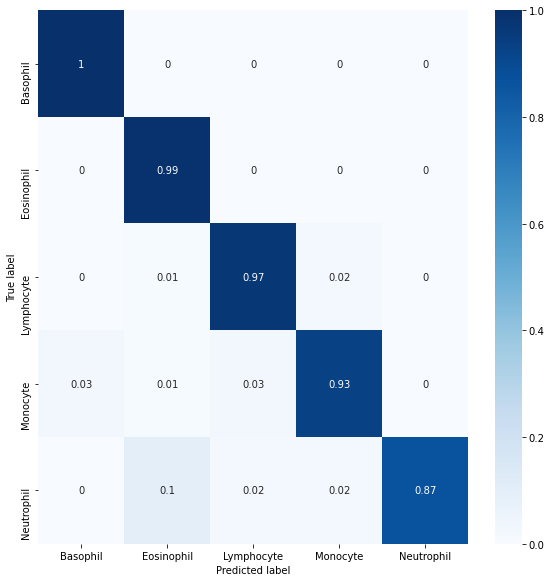

In [21]:
print(y_pred)
print(classes)
print(testdata.labels)

# Confusion Matrix
u.cm(y_pred,testdata.labels, classes)

In [4]:
# To get performance metrics
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

model.load_weights('Rabin Mobilenetv2.params')
classes = list(testdata.class_indices.keys())
y_pred=np.argmax(model.predict(testdata), axis=-1)
cnf_matrix = confusion_matrix(testdata.labels, y_pred)

In [5]:
metrics = pd.DataFrame(index =['Sensitivity', 'Specificity','Error'],
                   columns =  [x.title() for x in classes])
   
for i in range (0,len(cnf_matrix)):
    TP = cnf_matrix[i][i]
    FN = sum(cnf_matrix[i])-TP #row 
    FP = sum(cnf_matrix[:,i])-TP #col
    TN = sum(sum(cnf_matrix))-TP-FN-FP
    
    accuracy = TP/sum(cnf_matrix[i])
    error = 1-TP/sum(cnf_matrix[i])
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP) 
    
    metrics.iloc[0][i] = round(sensitivity,4)
    metrics.iloc[1][i] = round(specificity,4)
    metrics.iloc[2][i] = round(error,4)
    
print(metrics)

            Basophil Eosinophil Lymphocyte Monocyte Neutrophil
Sensitivity      1.0     0.9944     0.9677   0.9293     0.8662
Specificity   0.9924     0.9715     0.9862   0.9895     0.9998
Error            0.0     0.0056     0.0323   0.0707     0.1338
